In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

In [3]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde


X shape: (150, 4)
y shape: (150,)


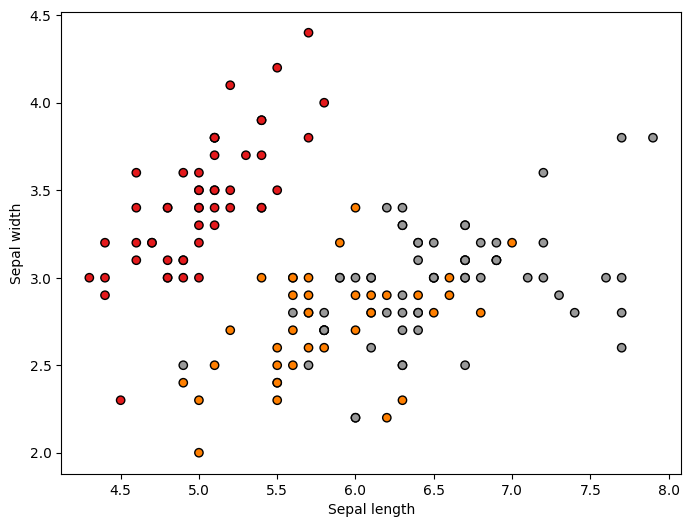

In [5]:
# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Target labels
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

#plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
plt.show()


# Preprocess the data (standardize)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(X)

In [7]:
iris = load_iris(as_frame=True).frame
labels = {0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}
iris['Species'] = iris.target.apply(lambda c: labels[c])
true_species = torch.from_numpy(iris['target'].values)
iris = iris.drop(columns='target')


In [17]:
# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)

class AffineCouplingLayer(nn.Module):

    def __init__(
            self,
            theta: nn.Module,
            split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]
    ):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1)
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)

class Conditioner(nn.Module):

    def __init__(
            self, in_dim: int, out_dim: int,
            num_hidden: int, hidden_dim: int,
            num_params: int
    ):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

Epoch [0/1000], Loss: 4.958097457885742
Epoch [100/1000], Loss: 2.6664209365844727
Epoch [200/1000], Loss: 1.8875603675842285
Epoch [300/1000], Loss: 1.564405918121338
Epoch [400/1000], Loss: 1.4402644634246826
Epoch [500/1000], Loss: 1.2697452306747437
Epoch [600/1000], Loss: 1.1631114482879639
Epoch [700/1000], Loss: 1.1226948499679565
Epoch [800/1000], Loss: 1.1014885902404785
Epoch [900/1000], Loss: 1.0936766862869263


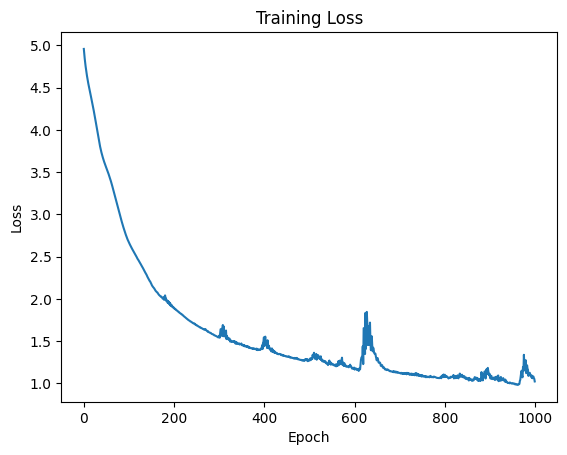

In [31]:
# Define the latent distribution (multivariate Gaussian)
latent_distribution = torch.distributions.MultivariateNormal(
    loc=torch.zeros(4), scale_tril=torch.eye(4)
)

# Create a list of flow layers (Affine Coupling layers) with a shared conditioner
conditioner = Conditioner(in_dim=2, out_dim=2, num_hidden=2, hidden_dim=32, num_params=2)
flows = [
    AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1))
    for _ in range(5)
]

# Create the Normalizing Flow model
flow_model = NormalizingFlow(latent_distribution, flows)

# Train the model (for demonstration purposes, you can adjust the training process)
optimizer = torch.optim.Adam(flow_model.parameters(), lr=0.001)

losses = []
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_prob = flow_model.log_prob(X_tensor)
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

# Generate samples from the trained model
with torch.no_grad():
    num_samples = 1000
    samples = flow_model.sample(num_samples=num_samples)
    samples = samples.numpy()

# Plot the loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

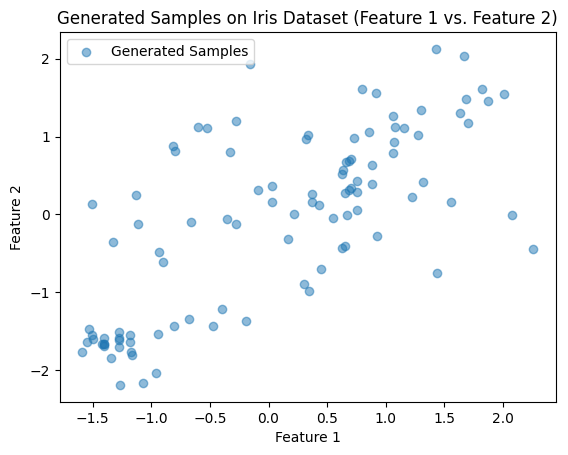

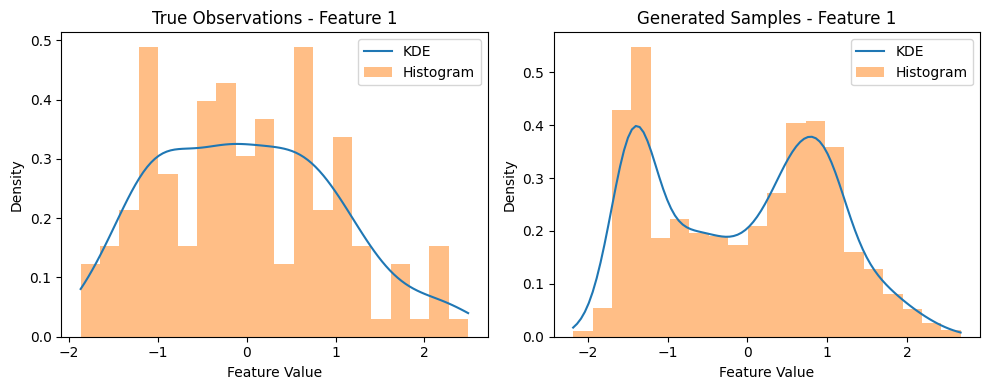

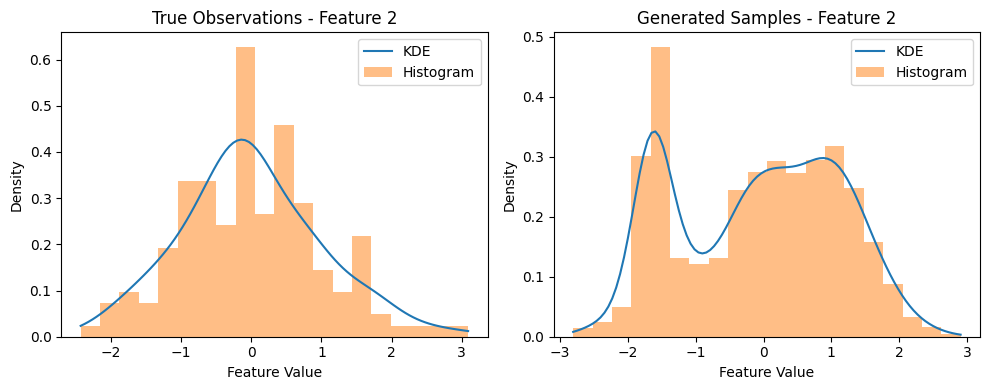

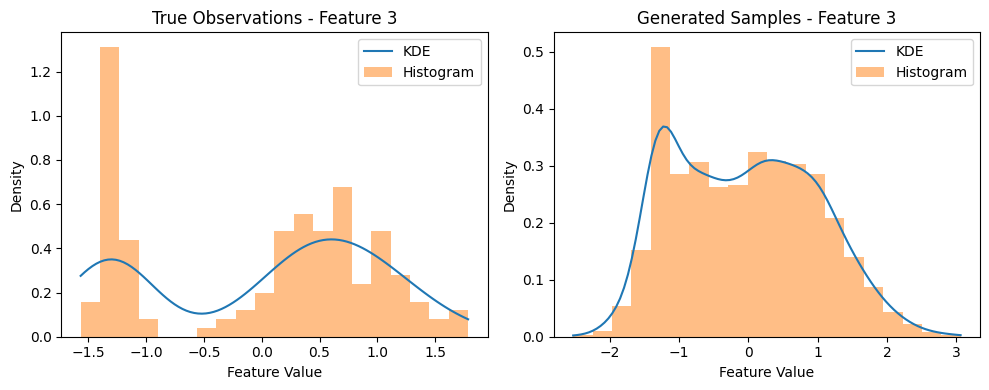

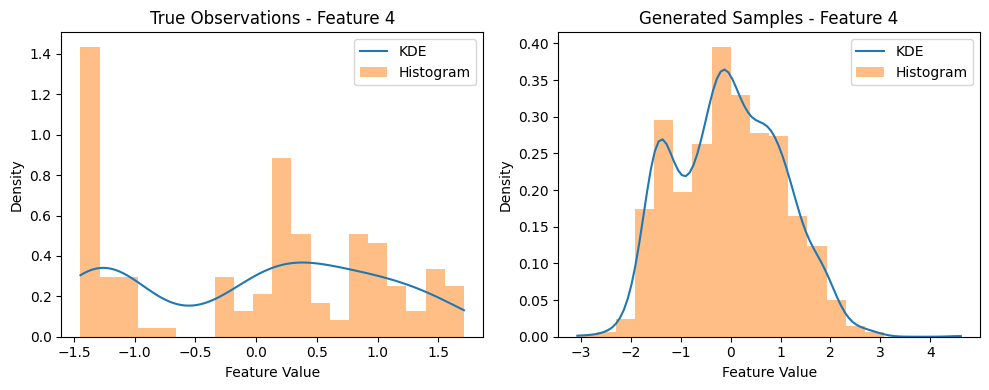

In [30]:


# Visualize the generated samples (for the first two features)
plt.scatter(samples[:, 0], samples[:, 1], label='Generated Samples', alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Samples on Iris Dataset (Feature 1 vs. Feature 2)")
plt.legend()
plt.show()

# Generate samples from the trained model
with torch.no_grad():
    num_samples = 2000
    generated_samples = flow_model.sample(num_samples=num_samples)
    generated_samples = generated_samples.numpy()

# Plot kernel density estimates for observations and generated samples
def plot_kde(data, title):
    kde = gaussian_kde(data.T)
    x = np.linspace(data.min(), data.max(), 100)
    y = kde(x)
    plt.plot(x, y, label='KDE')
    plt.hist(data, bins=20, density=True, alpha=0.5, label='Histogram')
    plt.title(title)
    plt.xlabel("Feature Value")
    plt.ylabel("Density")
    plt.legend()

# Plot kernel density estimates for each feature
for i in range(X.shape[1]):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plot_kde(X[:, i], f"True Observations - Feature {i + 1}")
    plt.subplot(1, 2, 2)
    plot_kde(generated_samples[:, i], f"Generated Samples - Feature {i + 1}")
    plt.tight_layout()
    plt.show()